# Titanic Survival Prediction

**Task:** Build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (i.e. name, age, gender, socio-economic class, etc.).


In [1]:
# Import relevant libraries
import numpy as np 
import numpy.linalg

import pandas as pd


import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import shapiro
from scipy import stats

from sklearn import metrics, preprocessing, feature_selection, linear_model, model_selection
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer


import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set_style("ticks")
from IPython.display import display
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Import file and check data

Data from https://www.kaggle.com/c/titanic/data
<br>
Data dictionary: https://polymall.polytechnic.edu.sg/bbcswebdav/pid-383968-dt-content-rid-10082431_1/courses/18S1-C-SP-098IT8302-10501966/Titanic%20Data%20Dictionary.html

In [2]:
# Read Excel data file
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_combined = df_train.append(df_test)

# Preview df
df_combined.tail()

PassengerId  Survived  Pclass                          Name     Sex  \
413         1305       NaN       3            Spector, Mr. Woolf    male   
414         1306       NaN       1  Oliva y Ocana, Dona. Fermina  female   
415         1307       NaN       3  Saether, Mr. Simon Sivertsen    male   
416         1308       NaN       3           Ware, Mr. Frederick    male   
417         1309       NaN       3      Peter, Master. Michael J    male   

      Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
413   NaN      0      0           A.5. 3236    8.0500   NaN        S  
414  39.0      0      0            PC 17758  108.9000  C105        C  
415  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416   NaN      0      0              359309    8.0500   NaN        S  
417   NaN      1      1                2668   22.3583   NaN        C

# 2. Exploratary Data Analyis 

## 2.1 Describe dataset

There are 891 observations (rows) and 12 variables (columns).

**Identifiers**
1. `PassengerId` Unique ID of passenger
2. `Name` Passenger name


**Categorical variables**
1. `Survived` Survival. 0 = No, 1 = Yes
2. `Pclass` Ticket class. 1 = 1st (Upper SES), 2 = 2nd (Middle SES), 3 = 3rd (Lower SES)
3. `Sex` Sex
4. `Ticket` Ticket number
5. `Cabin` Cabin number. The first letter denotes the deck.
6. `Embarked` Port of embarkation. C = Cherbourg, Q = Queenstown, S = Southampton

**Numerical variables**
1. `Age` Age in years
2. `Sibsp` # of siblings / spouses on board
3. `Parch` # of parents / children on board
4. `Fare` Passenger fare

In [3]:
### Show dataset shape and format
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Show descriptive stats
df_train.describe(include='all')

PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare    Cabin  \
count   714.000000  891.000000  891.000000     891  891.000000      204   
unique         NaN         NaN         NaN     681         NaN      147   
top            NaN         NaN         NaN  347082         NaN  B96 B98   
freq           NaN         NaN         NaN       7         NaN        4   
mean     29.699118    0.523008    0.381594     NaN   32.204208      NaN   
std      14.526497    1.102743    0.806057     NaN   49.693429      NaN   
min       0.420000    0.000000    0.000000     NaN    0.000000      NaN   
25%      20.125000    0.000000    0.000000     NaN    7.910400      NaN   
50%      28.000000    0.000000    0.000000     NaN   14.454200      NaN   
75%      38.000000    1.000000    0.000000     NaN   31.000000      NaN   
max      80.000000    8.000000    6.000000     NaN  512.329200      NaN   

       Embarked  
count       889  
unique        3  
top           S  
freq        644  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

## 2.2 Checking missing values

We notice the following columns have missing values:
1. `Cabin` (77% missing) With such a high number of missing values, it is unlikely we can perform a meaningful substitution. However, it is possible that Pclass and Fare could be indicators of cabin type. We explore this later. 
2. `Age` (20% missing) Since it is widely purported that **women** and **children** were given priority to board the lifeboats, Age may be a significant predictor and hence should not be excluded from the analysis yet. We explore how to impute values later.
3. `Embarked` (0.2% missing) Since it is a small number, we can substitute missing values with the most common value.

In [5]:
# Show fields with missing values

usedf = df_train

print("% of missing values:")
usedf.isnull().sum().sort_values(ascending = False)/len(usedf)

% of missing values:


Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

## 2.3 Analyse relationships between variables

Based on the correlation matrix, we observe
1. `Survived`, `Pclass` seem to have some weak negative correlation.
2. `Survived`,`Fare` seem to have some weak positive correlation.
3. `Fare`,`Pclass` are moderately correlated. It may be appropriate to remove one of the variables during modelling to minimise multicollinearity.
4. `Parch` and `SibSp` are moderately correlated. We can explore creating a combined `Relatives` variable to minimise multicollinearity.

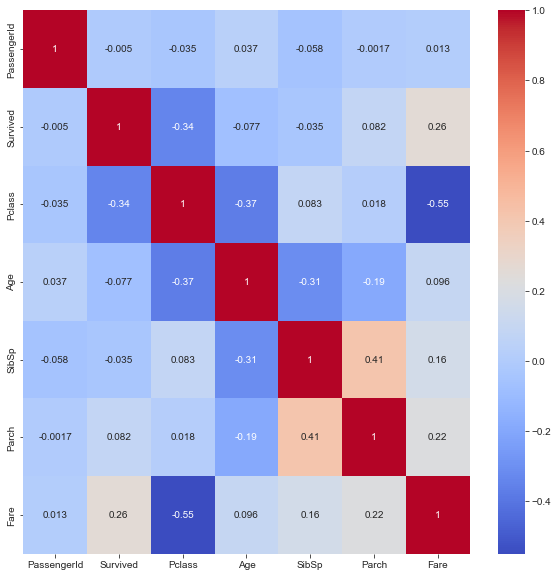

In [6]:
# Produce the correlation matrix

usedf = df_train

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(usedf.corr(), annot=True,cmap='coolwarm')


### 2.3.1 `Gender` appears to be related to survival

From the graphs, we observe:
1. Males have a lower probability of survival compared to females
2. At a glance, it appears that males aged 20 to 40 have around 50% chance of survival, but the survival rate drops drastically for males above 40. In contrast, females have around 75% to 100% chance of survival across all age bands. However, we note that `Age` has a high number of missing values.

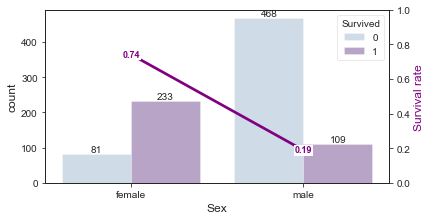

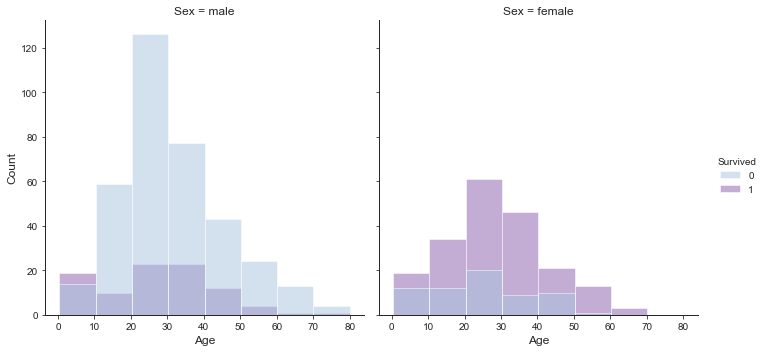

In [7]:
# -------------------------------------------
# Function to plot bar chart
def plotsplitbar_df_train(x,col):
    fig = plt.figure(figsize=(21,7))
    ax = fig.add_subplot(231)
    sns.countplot(x=x, data=df_train.sort_values(by=[x]), hue = col, palette="BuPu", alpha = 0.6)
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            ha='center', va='bottom')

# -------------------------------------------
# Function to plot bar chart and overlay with survival rate
def plotbaroversurvival_df_train(x):
    # Bar chart
    plotsplitbar_df_train(x,'Survived')
    
    # Survival rate
    ax2 = plt.twinx()
    ax2.set(ylim=(0,1))
    sns.pointplot(data = df_train.sort_values(by=[x]), x=x,y = 'Survived', color = 'purple', ci = None, ax = ax2)
    
    # Data labels
    mean_df = df_train.groupby(x)[['Survived']].mean().sort_values(by=[x])
    for i, row in enumerate(mean_df.itertuples()):

        x_value, mean = row

        plt.annotate(
            round(mean, 2),               # label text
            (i, mean),                    # (x, y)
            fontsize=9,
            color = 'purple',
            bbox=dict(pad=.9,alpha=1, fc='w',color='none'),
            va='center', ha='center',weight='bold'
            )
    
    plt.ylabel('Survival rate', color ='purple')

# ----------------------------------------------

# Plots

plotbaroversurvival_df_train('Sex')

# Plot distribution plot with bins
fig = sns.displot(data = df_train, x = 'Age', col = 'Sex', hue = 'Survived', bins = 8, palette="BuPu")

###  2.3.2. Possible interaction effects between `Sex` and `Parch`/`SibSp`
It may be possible that females with young children have a better chance of survival. Based on the interaction plots, we observe
1. `Sex` and `SibSp`: Survival rates decreased generally across `Sex`es when `SibSp` increased. However, the `Sex` lines are not parallel, indicating possible interaction effects.
2. `Sex` and `Parch`: Survival rates decreased generally across `Sex`es when `Parch` increased. However, the `Sex` lines are not parallel, indicating possible interaction effects.

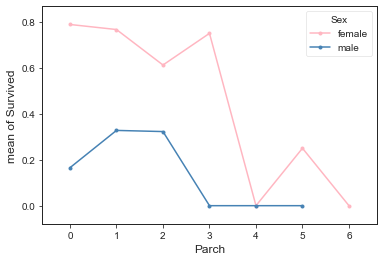

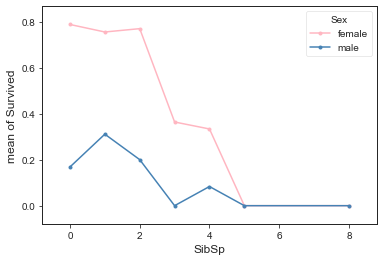

In [8]:
usedf = df_train

interaction_plot(x=usedf['Parch'], trace=usedf['Sex'], response=usedf['Survived'], colors=('lightpink','steelblue'))
plt.show()

interaction_plot(x=usedf['SibSp'], trace=usedf['Sex'], response=usedf['Survived'], colors=('lightpink','steelblue'))
plt.show()

### 2.3.3 `Pclass` appears to be related to survival
1. The survival rate is higher for higher `Pclass`. Pclass 1 = 63% survival, Pclass 2 = 47% survival, Pclass 3 = 24% survival.
2. The difference in survival rate is amplified when we consider `Sex`.
    * Males: Pclass 1 = 37% survival, Pclass 2 = 16% survival, Pclass 3 = 14% survival
    * Females: Pclass 1 = 97% survival, Pclass 2 = 92% survival, Pclass 3 = 50% survival


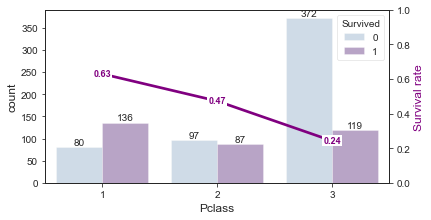

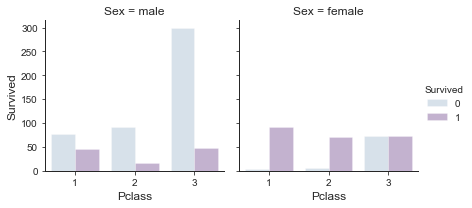

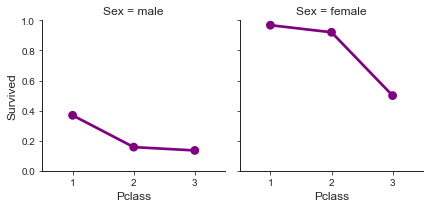

In [9]:
# Plot bar chart
plotbaroversurvival_df_train('Pclass')

def plotsurvivalgrid_df_train(col,x):
    
    def countplot(x, hue, **kwargs):
        sns.countplot(x=x, hue=hue, **kwargs)
    
    # Plot counts
    g = sns.FacetGrid(df_train, col = col)
    g.map(countplot, x,'Survived', alpha = 0.5, palette ='BuPu',order = sorted(df_train[x].unique()))
    g.add_legend(title='Survived')

    # Plot survival rate by Sex and Pclass
    g = sns.FacetGrid(df_train, col=col, ylim = (0,1))
    g.map(sns.pointplot, x,'Survived', color="purple" ,ci = None, order = sorted(df_train[x].unique()))
    g.add_legend()
    
          
plotsurvivalgrid_df_train('Sex','Pclass')

### 2.3.4 Location of `Cabin` appears to be related to survival, but may not be generalisable.

While more than half of the values in `Cabin` are missing, we can obtain information of the `Deck` on which cabin is located. The **first letter of the `Cabin` number is the `Deck`**. It's possible that those located at a higher deck could have reached the lifeboats sooner - hence, we create a numerical `Deck` variable to see if location is related to suvival.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Olympic_%26_Titanic_cutaway_diagram.png/1280px-Olympic_%26_Titanic_cutaway_diagram.png" width="300"/>
</div>

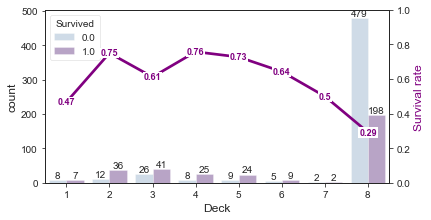

In [10]:
# ------------------------------------------
# Create Deck variable that denotes the deck level

# We perform this over df_combined since we need to apply over the whole dataset.


# Create Deck variable
df_combined['Deck']=df_combined['Cabin'].str[:1]


# Fill in missing deck info
# We assume those with the same ticket number belong to the same deck.
# We use this info to try to impute some missing values.

# Create lookup table for ticket and cabin
lookuptable = df_combined[['Ticket','Deck']].dropna().drop_duplicates('Ticket').rename(columns={"Deck": "Deck_lookup"})

# Add Deck_lookup column to main df using merge
df_combined = pd.merge(df_combined,lookuptable, on = 'Ticket',how = 'left')

# Replace NaNs in Deck with Deck_lookup
df_combined['Deck'].fillna(df_combined['Deck_lookup'], inplace=True)
df_combined.drop(columns = 'Deck_lookup', inplace = True)

# Convert Deck letter to number
decklevel = {"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
df_combined['Deck'] = df_combined['Deck'].map(decklevel)

# Replace missing deck levels with 0
df_combined['Deck']= df_combined['Deck'].fillna(8).astype(int)


# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


# -------------------------------------------
# Plots

plotbaroversurvival_df_train('Deck')

It appears that the probability of survival is higher for at `Deck` = 2, 4, and 5, but there is a good portion of data missing (i.e. `Deck` = 8) hence the observation may not be generalisable.

### 2.3.5 `Pclass` could be a high-level indicator of `Deck`

From the chart below, we notice that
* `Pclass` = 1 occupies cabins at the 1st to 5th deck
* `Pclass` = 2 occupies cabins at the 4th to 6th deck
* `Pclass` = 3 occupies cabins at the 5th to 7th deck

Considering the lack of data on `Cabin` and hence `Deck`, we can consider using `Pclass` as a high-level proxy. But can `Deck` be approximated better?

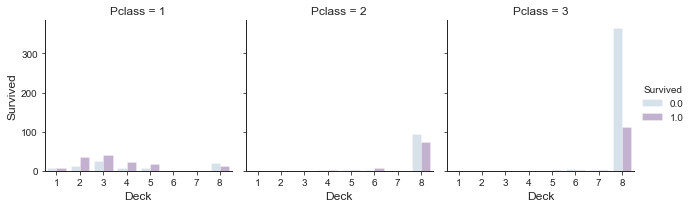

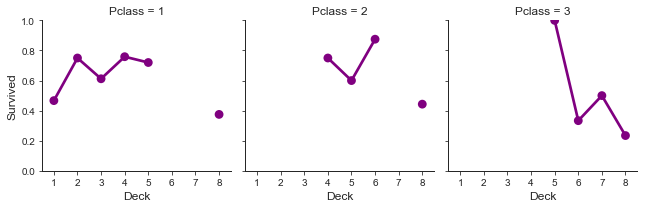

In [11]:
# Plot distribution plot

plotsurvivalgrid_df_train('Pclass','Deck')

### 2.3.6 `Fare_per_pax` is not a good indicator of `Deck`, but is a good indicator of `Pclass`

We explore if `Fare` can be an indicator of `Deck`, assuming that upper decks are more expensive.
<br>We derive a `Fare_per_pax`variable, dividing `Fare` by the counts of `Ticket`.
<br>However, the boxplot shows no visible differences in the average `Fare` per person in different decks. In fact, `Fare` was a better indicator of `Pclass` and we may explore dropping either `Fare` or `Pclass` from the model to minimise multicollinearity.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  import sys


<AxesSubplot:xlabel='Pclass', ylabel='Fare_per_pax'>

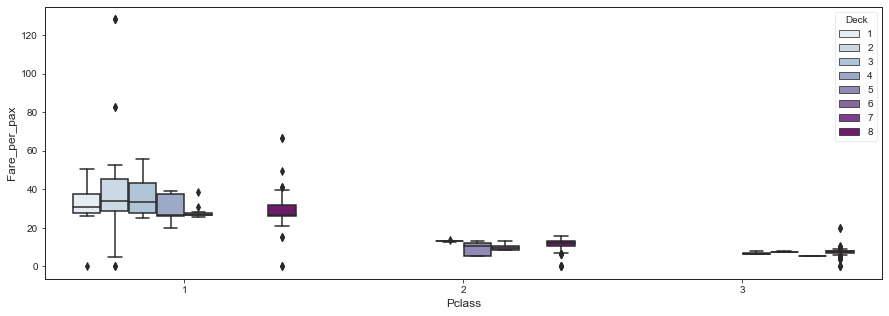

In [12]:
# --------------------------------------------------
# Create Fare_per_pax variable

# We perform this over df_combined since we need to apply over the whole dataset.

# There is 1 entry without Fare and Fare per pax. We use mean substitution by Pclass-SibSp-Parch group.
df_combined['Fare'].fillna(df_combined.groupby(['Pclass','SibSp','Parch']).transform('mean').Fare, inplace=True)



# Count no. of persons per ticket
df3 = df_combined.groupby(['Ticket'])['Name'].count().reset_index().rename(columns={"Name": "Pax"})

# Remove duplicates for Fare (using max for each ticket number since the fare is the same for each ticket number)
df4 = df_combined.groupby(['Ticket'])['Fare'].max().reset_index()

# Create table for ticket, persons per ticket and fare
df5 = pd.merge(df3, df4, on = 'Ticket')

# Caclulate fare per pax
df5['Fare_per_pax'] = df5['Fare']/df5['Pax']

# Drop Pax and Fare column and merge back to main df
df5 = df5[['Ticket','Fare_per_pax']]
df_combined = pd.merge(df_combined, df5, on = 'Ticket')



# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


# --------------------------------------------------
# Plot boxplot

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x = 'Pclass',y = 'Fare_per_pax', hue='Deck', data = df_train, palette = 'BuPu')

### 2.3.7 Where a passenger `Embarked` appears to be related to survival.

Titanic called at the ports in the following order:
1. Southampton `Embarked` = S
2. Cherbourg `Embarked` = C
3. Queenstown `Embarked` = Q

We observe:
1. Most of the passengers boarded at Southampton
2. Survival rate is generally higher for those who embarked later at **Cherbourg** and **Queenstown**.

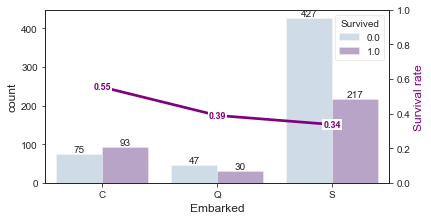

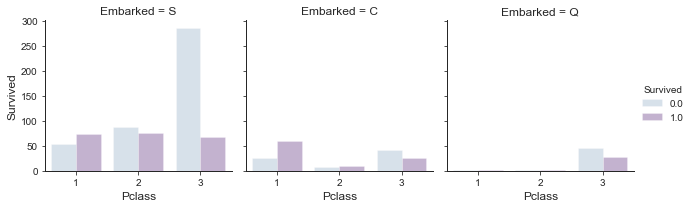

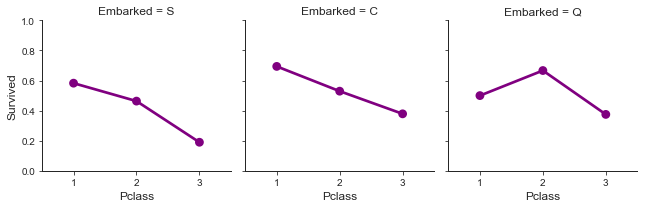

In [13]:
plotbaroversurvival_df_train('Embarked')
plotsurvivalgrid_df_train('Embarked','Pclass')

# 3. Data Processing

## 3.1 Handle missing values

### 3.1.1 `Cabin`: drop the column
There are too many missing values in `Cabin`, and it is unlikely we can perform a meaningful substitution. We explored possiblilites of approximating the cabin location though `Fare`, `Pclass` and `Deck` relationships in 2.3.3 to 2.3.5, and found that `Pclass` could be a high-level proxy for `Cabin`. Hence we will drop `Cabin` for now to minimize multicollinearity.

In [14]:
df_combined.drop(columns = 'Cabin', inplace=True)

# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]

### 3.1.2 `Embarked`: use mode substitution
`Embarked` has 2 missing values, and both hold the same ticket. In the absence of further info, we will subsitute missing values with the most common port (i.e. substitute with mode).

In [15]:
# We perform this over df_combined since we need to apply over the whole dataset.

# Substitute missing values in Embarked with mode
df_combined['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace=True)

# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]

# Show record
df_train.loc[df_train['Ticket'] == '113572']

PassengerId  Survived  Pclass                                       Name  \
130           62       1.0       1                        Icard, Miss. Amelie   
131          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Embarked  Deck  Fare_per_pax  
130  female  38.0      0      0  113572  80.0        S     2          40.0  
131  female  62.0      0      0  113572  80.0        S     2          40.0

### 3.1.3 `Age`: impute using median substitution

Since it is widely purported that **women** and **children** were given priority to board the lifeboats, `Age` may be a significant predictor and hence should not be excluded from the analysis yet.

We consider the following:
1. `Age` may be approximated based on one's `Title`, which is embedded in `Name`. For example, "Master" is typically used for young boys.
2. `Age` may also be approximated based on `Parch`, i.e. the number of parents/children on board.
3. `Age` may be skewed. If so, median substitution may be more appropriate for skewed distributions.


<AxesSubplot:xlabel='Title', ylabel='Age'>

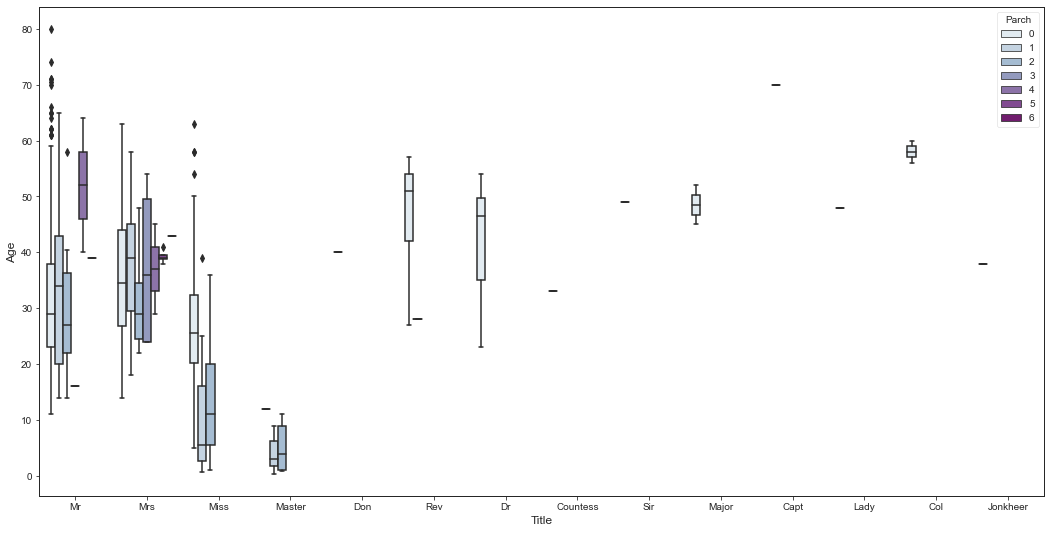

In [16]:
# --------------------------------------------------
# Create Title variable

# We perform this over df_combined since we need to apply over the whole dataset.

# Extract title from name using REGEX
df_combined['Title']=df_combined.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# Replace "Ms" and "Mlle" with "Miss" (3 records)
df_combined['Title']=df_combined.Title.replace(('Ms','Mlle'),'Miss')

# Replace "Mme" with "Mrs" (1 record)
df_combined['Title']=df_combined.Title.replace('Mme','Mrs')


# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


# ---------------------------------------------------
# Analyse if age distribution is different across Title and Parch groups

# Plot age distribution
plt.figure(figsize=(18,9))
plt.tight_layout()
sns.boxplot(x = 'Title',y = 'Age', hue='Parch', data = df_train, palette = 'BuPu')


Based on the age distribution in the boxplot, we observe
1. Mean/median age is different across different `Title`-`Parch` groups, some more significantly different (when boxplots do not overlap) than others
2. There is some skewness in `Age`.

<br>Hence, we use **median substitution** (to account for skewness) for missing values in each `Title`-`Parch` group **to be more representative**.
<br> We also create a catergorical variable `Age_group` by binning `Age` - we will later explore if it helps to reduce noise.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  import sys


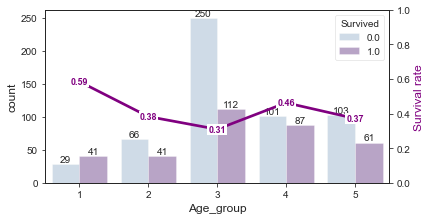

In [17]:
# We perform this over df_combined since we need to apply over the whole dataset.

# Impute missing ages with median of the Title-Parch group
df_combined['Age'].fillna(df_combined.groupby(['Title', 'Parch']).transform('median').Age, inplace=True)

# There are still 2 people with missing age. Impute missing ages with median of Title group.
df_combined['Age'].fillna(df_combined.groupby(['Title']).transform('median').Age, inplace=True)


# Create Age_group column derived from Age_imputed
bins = [0,10,20,30,40,110]
labels = ['1','2','3','4','5']
df_combined['Age_group']= pd.cut(df_combined['Age'], bins=bins, labels=labels, right=False)

# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


# Plot bar chart to view the counts in Age_group
plotbaroversurvival_df_train('Age_group')

## 3.2 Convert categorical features
Convert `Sex` and `Embarked` into numeric categories. Generate dummies for `Title`.

In [18]:
# We perform this over df_combined since we need to apply over the whole dataset.

# Create dummy variables for Sex.
#We do this without one-hot encoding so that we can explore further interaction effects with Sex, if any.
df_combined = pd.get_dummies(df_combined, columns=['Sex'])


# Convert Embarked to numeric. We maintain this as an ordinal column to preserve the order of boarding.
port = {"S":1, "C":2, "Q":3}
df_combined['Embarked_ordinal'] = df_combined['Embarked'].map(port)


# Create dummy variables for Embarked
df_combined = pd.get_dummies(df_combined, columns=['Embarked'])

# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]

In [19]:
# Generate dummies for Title groups.

# Create groups for title
Title_bin = {'Mr': 'Mr','Master':'Master',
             'Don':'Reputable_M','Rev':'Reputable_M','Dr':'Reputable_M','Sir':'Reputable_M','Major':'Reputable_M','Capt':'Reputable_M','Col':'Reputable_M','Jonkheer':'Reputable_M',
             'Mrs':'Mrs','Miss':'Miss',
             'Countess':'Reputable_F', 'Dona':'Reputable_F','Lady':'Reputable_F'
            }

df_combined['Title_bin']=df_combined['Title'].map(Title_bin)


# There is one female Dr (PassengerId = 797) so we will change that
df_combined.loc[df_combined['PassengerId'] == 797,'Title_bin'] = 'Reputable_F'

print(df_combined['Title_bin'].unique())

# Create dummy variables for Title_bin.
#We do this without one-hot encoding so that we can explore further interaction effects with Title_bin, if any.
df_combined = pd.get_dummies(df_combined, columns=['Title_bin'])


# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


pd.options.display.max_columns = None
df_test.tail()


['Mr' 'Mrs' 'Miss' 'Master' 'Reputable_M' 'Reputable_F']


PassengerId  Survived  Pclass                            Name   Age  \
1304         1302       NaN       3          Naughton, Miss. Hannah  25.0   
1305         1304       NaN       3  Henriksson, Miss. Jenny Lovisa  28.0   
1306         1305       NaN       3              Spector, Mr. Woolf  29.0   
1307         1307       NaN       3    Saether, Mr. Simon Sivertsen  38.5   
1308         1308       NaN       3             Ware, Mr. Frederick  29.0   

      SibSp  Parch              Ticket   Fare  Deck  Fare_per_pax Title  \
1304      0      0              365237  7.750     8         7.750  Miss   
1305      0      0              347086  7.775     8         7.775  Miss   
1306      0      0           A.5. 3236  8.050     8         8.050    Mr   
1307      0      0  SOTON/O.Q. 3101262  7.250     8         7.250    Mr   
1308      0      0              359309  8.050     8         8.050    Mr   

     Age_group  Sex_female  Sex_male  Embarked_ordinal  Embarked_C  \
1304         3           1         0                 3           0   
1305         3           1         0                 1           0   
1306         3           0         1                 1           0   
1307         4           0         1                 1           0   
1308         3           0         1                 1           0   

      Embarked_Q  Embarked_S  Title_bin_Master  Title_bin_Miss  Title_bin_Mr  \
1304           1           0                 0               1             0   
1305           0           1                 0               1             0   
1306           0           1                 0               0             1   
1307           0           1                 0               0             1   
1308           0           1                 0               0             1   

      Title_bin_Mrs  Title_bin_Reputable_F  Title_bin_Reputable_M  
1304              0                      0                      0  
1305              0                      0                      0  
1306              0                      0                      0  
1307              0                      0                      0  
1308              0                      0                      0

## 3.3 Feature engineering

To recap, we created `Title`, `Deck`, and `Fare_per_pax` earlier. Now we generate more features to prepare for modelling

### 3.3.1 Create `Reputable` variable
It is possible that persons belonging to the upper echelons of society may have been accorded more privileges which could increase their chances of survival. We classify those that have honorific `Title`s as `Reputable`.

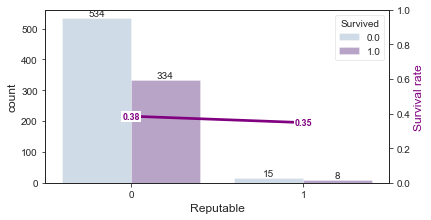

In [20]:
# We perform this over df_combined since we need to apply over the whole dataset.

reputable = {'Mr': 0,'Mrs':0,'Miss':0,'Master':0}
df_combined['Reputable']=df_combined['Title'].map(reputable).fillna(1).astype(int)

# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]

plotbaroversurvival_df_train('Reputable')

### 3.3.2 Create `Relatives` and `Alone` variables
We can sum `SibSp` and `Parch` to obtain the number of `Relatives` onboard. We create a `Alone` to indicate lone travellers

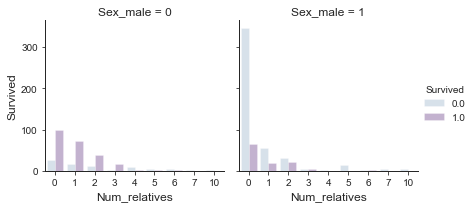

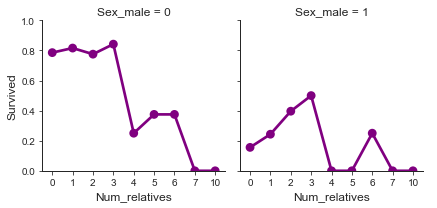

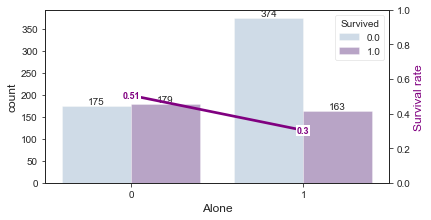

In [21]:
# We perform this over df_combined since we need to apply over the whole dataset.

# Create Relatives column
df_combined['Num_relatives']=df_combined['SibSp']+df_combined['Parch']

# Create Alone column (alone = 1, not alone = 0)
df_combined['Alone']= df_combined['Num_relatives'].map({0:1}).fillna(0).astype(int)

# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


plotsurvivalgrid_df_train('Sex_male','Num_relatives')
plotbaroversurvival_df_train('Alone')

### 3.3.3 Create `Family_with_child` variable

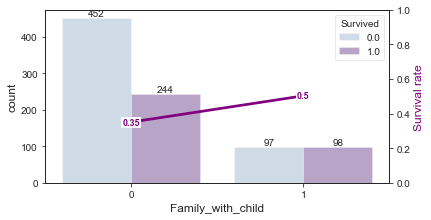

In [22]:
# Those travelling with the same ticket number are likely family or close relations.
# Sometimes, those with different surnames have the same ticket number. These could be siblings where one is married and took on the husband's surname.
# As there are many passengers with the same surname, surname can't be used as a key.

# Create Family_with_child variable, where family = same ticket number

# Create Child indicator
df_combined['Child'] = df_combined['Age'].map(lambda x: 1 if x <=16 else 0)

#Create Family_with_child variable
df_combined['Family_with_child'] = df_combined.groupby(['Ticket'])['Child'].transform('max')
df_combined.head()


# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


plotbaroversurvival_df_train('Family_with_child')

### 3.3.4 Create `Family_with_survival` variable

In [36]:
# Remember, 'Survived' is blank for testing data.
# So we will use training data to map - family with survivors = 1, unsure = 0


#Create Family_with_survival variable
df_train['Family_with_survival'] = df_train.groupby(['Ticket'])['Survived'].transform('max').astype(int)



# Merge with main dataset
df_combined = pd.merge(df_combined, df_train[['Ticket','Family_with_survival']].drop_duplicates(),
                  on = 'Ticket', how = 'left')

df_combined['Family_with_survival'] = pd.to_numeric(df_combined['Family_with_survival'], errors='coerce')
df_combined['Family_with_survival'] = df_combined['Family_with_survival'].fillna(0).astype(int)



# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


<AxesSubplot:xlabel='Num_relatives', ylabel='count'>

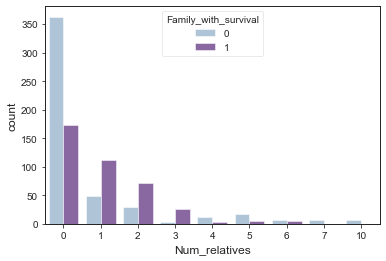

In [37]:
sns.countplot(data=df_train, x = 'Num_relatives', hue = 'Family_with_survival',palette = 'BuPu')

### 3.3.5 Explore some interaction variables

In [38]:
# Sex and Parch
df_combined['Male_Parch'] = df_combined['Sex_male']*df_combined['Parch']
df_combined['Female_Parch'] = df_combined['Sex_female']*df_combined['Parch']*-1
df_combined['Sex_Parch'] = df_combined['Male_Parch']+df_combined['Female_Parch']


# Split df_combined and overwrite df_train and df_test
df_train = df_combined[df_combined['Survived'].notna()]
df_test = df_combined[df_combined['Survived'].isnull()]


### 3.3.6 Check final datasets

In [39]:
df_train.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
3            3       1.0       3   
4            4       1.0       1   
5          138       0.0       1   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
3                             Heikkinen, Miss. Laina  26.0      0      0   
4       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
5                        Futrelle, Mr. Jacques Heath  37.0      1      0   

             Ticket     Fare  Deck  Fare_per_pax Title Age_group  Sex_female  \
0         A/5 21171   7.2500     8       7.25000    Mr         3           0   
1          PC 17599  71.2833     3      35.64165   Mrs         4           1   
3  STON/O2. 3101282   7.9250     8       7.92500  Miss         3           1   
4            113803  53.1000     3      26.55000   Mrs         4           1   
5            113803  53.1000     3      26.55000    Mr         4           0   

   Sex_male  Embarked_ordinal  Embarked_C  Embarked_Q  Embarked_S  \
0         1                 1           0           0           1   
1         0                 2           1           0           0   
3         0                 1           0           0           1   
4         0                 1           0           0           1   
5         1                 1           0           0           1   

   Title_bin_Master  Title_bin_Miss  Title_bin_Mr  Title_bin_Mrs  \
0                 0               0             1              0   
1                 0               0             0              1   
3                 0               1             0              0   
4                 0               0             0              1   
5                 0               0             1              0   

   Title_bin_Reputable_F  Title_bin_Reputable_M  Reputable  Num_relatives  \
0                      0                      0          0              1   
1                      0                      0          0              1   
3                      0                      0          0              0   
4                      0                      0          0              1   
5                      0                      0          0              1   

   Alone  Child  Family_with_child  Family_with_survival_x  Male_Parch  \
0      0      0                  0                       0           0   
1      0      0                  0                       1           0   
3      1      0                  0                       1           0   
4      0      0                  0                       1           0   
5      0      0                  0                       1           0   

   Female_Parch  Sex_Parch  Family_with_survival_y  Family_with_survival  
0             0          0                     0.0                     0  
1             0          0                     1.0                     1  
3             0          0                     1.0                     1  
4             0          0                     1.0                     1  
5             0          0                     1.0                     1

In [40]:
df_test.to_csv('cleaned_df_test.csv',index=False)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   PassengerId             1309 non-null   int64   
 1   Survived                891 non-null    float64 
 2   Pclass                  1309 non-null   int64   
 3   Name                    1309 non-null   object  
 4   Age                     1309 non-null   float64 
 5   SibSp                   1309 non-null   int64   
 6   Parch                   1309 non-null   int64   
 7   Ticket                  1309 non-null   object  
 8   Fare                    1309 non-null   float64 
 9   Deck                    1309 non-null   int64   
 10  Fare_per_pax            1309 non-null   float64 
 11  Title                   1309 non-null   object  
 12  Age_group               1309 non-null   category
 13  Sex_female              1309 non-null   uint8   
 14  Sex_male                

# 4. Building the model

 ## 4.1 Set up functions

In [41]:
# Define function to generate metrics for classification

def classification_metrics(cv):
    print("*"*60)
    modelname = [item for item in steps if item[0]=='model'][0][1]
    print("METHOD: {}".format(modelname))
    print("*"*60,end='\n\n')

    print("Features: {}".format(X.columns.tolist()))
    print("Standardized features: {}".format(to_scale))
    print("Tuned Model Parameters: {}".format(cv.best_params_))

    # Metrics
    print('\n')
    print("========== Metrics ==========" ,end='\n\n')
    print("Accuracy: {:.3f}".format(cv.score(X_test, y_test)))
    print("AUC: {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    r2 = cv.score(X_test, y_test)
    print("R²: {:.3f}".format(r2))
    r2_adj = 1 - ( 1-cv.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )
    print("Adjusted R²: {:.3f}".format(r2_adj))

    print('\n')
    print("=== Classification Report ===" ,end='\n\n')
    print(metrics.classification_report(y_test, y_pred))

    # Plots
    fig = plt.figure(figsize=(8,3))

    # ROC curve
    plt.subplot(1,2,1)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    # Confusion matrix
    plt.subplot(1,2,2)
    cm = metrics.confusion_matrix(y_test, y_pred, labels=cv.classes_)
    sns.heatmap(cm, annot=True, cmap="BuPu")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label') 
    plt.ylabel('True label')
    plt.show()
    
# --------------------------------------------------------------------------------------   
# Show feature importances by coef
def plot_feature_importance_coef(cv):
    features = X.columns.tolist()
    importances = cv.best_estimator_.named_steps['model'].coef_[0]

    feturedf=pd.DataFrame({'Features':features,'Importances':importances})
    feturedf.sort_values('Importances',inplace=True)

    fig = plt.figure(figsize=(7,4))
    feturedf.plot(kind='barh',y='Importances',x='Features',color='gray')
    plt.xlabel("Coefficients")
    plt.title('Feature Importance')
    plt.show()
    
# --------------------------------------------------------------------------------------       
# Show feature importances by feature_importances
def plot_feature_importance(cv):
    features = X.columns.tolist()
    importances = cv.best_estimator_.named_steps['model'].feature_importances_[0]

    feturedf=pd.DataFrame({'Features':features,'Importances':importances})
    feturedf.sort_values('Importances',inplace=True)

    fig = plt.figure(figsize=(7,4))
    feturedf.plot(kind='barh',y='Importances',x='Features',color='gray')
    plt.xlabel("Feature Importances")
    plt.title('Feature Importance')
    plt.show()
    
# --------------------------------------------------------------------------------------       
# Check permutation importance
def plot_perm_importance(cv):
    perm_importance = permutation_importance(cv, X_train, y_train)

    feature_names = X.columns.tolist()
    features = np.array(feature_names)
    sorted_idx = perm_importance.importances_mean.argsort()

    fig = plt.figure(figsize=(7,4))
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], color = 'gray')
    plt.xlabel("Permutation Importance")
    plt.title('Permutation Importance')
    plt.show()
    
    
# --------------------------------------------------------------------------------------
# Predict on X_topredict and output as a csv file
def predict_submission():
    modelname = [item for item in steps if item[0]=='model'][0][1]
    new_y_predict = pd.DataFrame(cv.predict(X_topredict)).reset_index(drop=True)

    predictions_df = pd.concat([df_test[['PassengerId']].reset_index(drop=True), new_y_predict], axis=1,ignore_index=True)
    predictions_df.rename(columns={0: "PassengerId",1: "Survived"}, inplace = True)

    predictions_df.to_csv('predictions_'+str(modelname)+'.csv',index=False)

## 4.2 Explore models

### 4.2.1 Support Vector Classification

************************************************************
METHOD: SVC()
************************************************************

Features: ['Pclass', 'Age', 'Num_relatives', 'Sex_male']
Standardized features: ['Pclass', 'Age', 'Num_relatives', 'Sex_male']
Tuned Model Parameters: {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


========== Metrics ==========

Accuracy: 0.821
AUC: 0.802
R²: 0.821
Adjusted R²: 0.828


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       111
         1.0       0.79      0.72      0.75        68

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



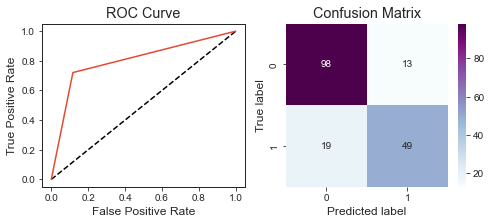

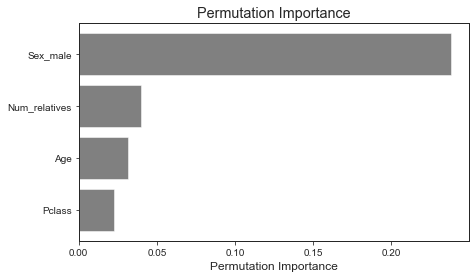

In [42]:
from sklearn.svm import SVC

# Choose variables to model
y = df_train['Survived']
X_var = ['Pclass', 'Age', 'Num_relatives', 'Sex_male']
to_scale = ['Pclass', 'Age', 'Num_relatives', 'Sex_male']
#best = ['Pclass', 'Age', 'Num_relatives', 'Sex_male']


X = df_train[X_var]
# allX = 'Pclass','Age','SibSp','Parch','Deck','Fare_per_pax','Sex_male','Embarked_C','Embarked_Q','Embarked_S','Title_bin_Master','Title_bin_Miss','Title_bin_Mr','Title_bin_Mrs','Title_bin_Reputable_F','Title_bin_Reputable_M','Reputable','Num_relatives','Alone','Family_with_child','Family_with_survival','Male_Parch','Female_Parch','Sex_Parch'
X_topredict = df_test[X_var]


# Set up pipeline
preprocessor = ColumnTransformer([('scaler', preprocessing.StandardScaler(),to_scale)],
                                 remainder='passthrough')

steps = [('preprocessor', preprocessor),
         ('model',SVC())
        ]
    
pipeline = Pipeline(steps)

# Specify hyperparameter space
parameters = {'model__C':[1,10,100],
              'model__gamma':[0.1,0.01],
              'model__kernel': ('linear', 'rbf')
             }


# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=21)

# Instantiate the GridSearchCV object: cv
cv = model_selection.GridSearchCV(pipeline,parameters, cv=5)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the set: y_pred
y_pred = cv.predict(X_test)

# Store SVC training accuracy
svc_train_accuracy = cv.score(X_test, y_test)


classification_metrics(cv)

plot_perm_importance(cv)

predict_submission()

### 4.2.2 Logistic Regression

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

************************************************************
METHOD: LogisticRegression()
************************************************************

Features: ['Pclass', 'Age', 'Parch', 'Sex_male', 'Sex_Parch', 'Deck']
Standardized features: ['Pclass', 'Age', 'Parch', 'Sex_male', 'Sex_Parch', 'Deck']
Tuned Model Parameters: {'model__C': 21.54434690031882, 'model__penalty': 'l2'}


========== Metrics ==========

Accuracy: 0.832
AUC: 0.819
R²: 0.832
Adjusted R²: 0.791


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       111
         1.0       0.79      0.76      0.78        68

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



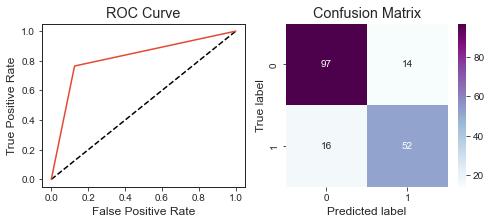

<Figure size 504x288 with 0 Axes>

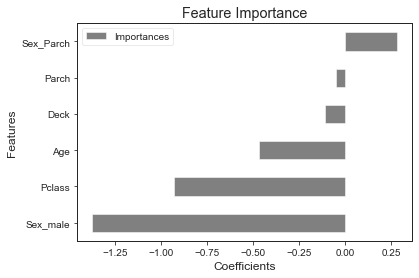

In [43]:
from sklearn.linear_model import LogisticRegression

# Choose variables to model
y = df_train['Survived']
X_var = ['Pclass','Age','Parch','Sex_male','Sex_Parch','Deck']
to_scale = ['Pclass','Age','Parch','Sex_male','Sex_Parch','Deck']
# best = 'Pclass','Age','Parch','Sex_male','Sex_Parch','Deck'
         
X = df_train[X_var]
X_topredict = df_test[X_var]


# Set up pipeline
preprocessor = ColumnTransformer([('scaler', preprocessing.StandardScaler(),to_scale)],
                                 remainder='passthrough')

steps = [('preprocessor', preprocessor),
         ("model", LogisticRegression())
        ]
    
pipeline = Pipeline(steps)

# Specify hyperparameter space
parameters = {"model__C": np.logspace(-4, 4, 4),
              "model__penalty":('l1', 'l2', 'elasticnet')
             }


# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=21)


# Instantiate the GridSearchCV object: cv
cv = model_selection.GridSearchCV(pipeline,parameters, cv = 5)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the set: y_pred
y_pred = cv.predict(X_test)

# Store logreg training accuracy
logreg_train_accuracy = cv.score(X_test, y_test)

classification_metrics(cv)
    
plot_feature_importance_coef(cv)

predict_submission()

### 4.2.3 K-Nearest Neighbours

************************************************************
METHOD: KNeighborsClassifier()
************************************************************

Features: ['Pclass', 'Age', 'Num_relatives', 'Fare_per_pax', 'Sex_male', 'Reputable']
Standardized features: ['Pclass', 'Age', 'Num_relatives', 'Fare_per_pax', 'Sex_male', 'Reputable']
Tuned Model Parameters: {'model__n_neighbors': 24, 'model__weights': 'distance'}


========== Metrics ==========

Accuracy: 0.788
AUC: 0.769
R²: 0.788
Adjusted R²: 0.947


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83       111
         1.0       0.73      0.69      0.71        68

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



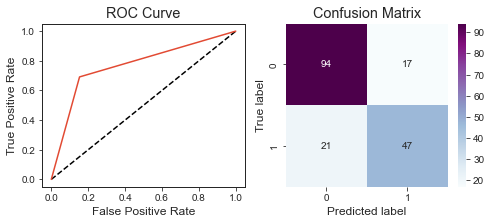

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Choose variables to model
y = df_train['Survived']
X_var = ['Pclass','Age','Num_relatives','Fare_per_pax','Sex_male','Reputable']
to_scale = ['Pclass','Age','Num_relatives','Fare_per_pax','Sex_male','Reputable']
#best = 'Pclass','Age','Num_relatives','Fare_per_pax','Sex_male','Reputable'

X = df_train[X_var]
X_topredict = df_test[X_var]


# Set up pipeline
preprocessor = ColumnTransformer([('scaler', preprocessing.StandardScaler(),to_scale)],
                                 remainder='passthrough')

steps = [('preprocessor', preprocessor),
         ('model', KNeighborsClassifier())
        ]
    
pipeline = Pipeline(steps)

# Specify hyperparameter space
parameters = {'model__n_neighbors': np.arange(3,30,3),
              'model__weights': ['uniform', 'distance']
              }

# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=21)

# Instantiate the GridSearchCV object: cv
cv = model_selection.GridSearchCV(pipeline,parameters, cv = 5)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the set: y_pred
y_pred = cv.predict(X_test)

# Store KNN training accuracy
knn_train_accuracy = cv.score(X_test, y_test)


classification_metrics(cv)

predict_submission()


### 4.2.4 Naive Bayes

************************************************************
METHOD: GaussianNB()
************************************************************

Features: ['Pclass', 'Age', 'Num_relatives', 'Sex_male']
Standardized features: ['Pclass', 'Age', 'Num_relatives', 'Sex_male']
Tuned Model Parameters: {'model__priors': None, 'model__var_smoothing': 0.43287612810830584}


========== Metrics ==========

Accuracy: 0.816
AUC: 0.794
R²: 0.816
Adjusted R²: 0.804


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       111
         1.0       0.79      0.71      0.74        68

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



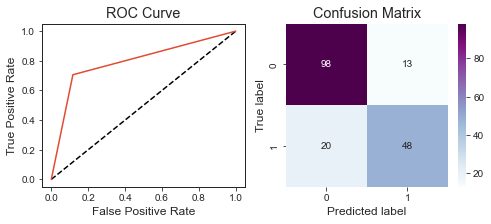

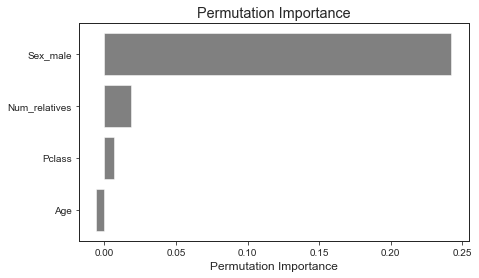

In [45]:
from sklearn.naive_bayes import GaussianNB

# Choose variables to model
y = df_train['Survived']
X_var = ['Pclass','Age','Num_relatives','Sex_male']
to_scale = ['Pclass','Age','Num_relatives','Sex_male']
#best = 'Pclass','Age','Num_relatives','Sex_male'


X = df_train[X_var]
X_topredict = df_test[X_var]


# Set up pipeline
preprocessor = ColumnTransformer([('scaler', preprocessing.StandardScaler(),to_scale)],
                                 remainder='passthrough')

steps = [('preprocessor', preprocessor),
         ("model", GaussianNB()),
        ]
    
pipeline = Pipeline(steps)

# Specify hyperparameter space
parameters = {'model__priors': [None],
              'model__var_smoothing': np.logspace(0,-9, num=100)
             }


# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=21)


# Instantiate the GridSearchCV object: cv
cv = model_selection.GridSearchCV(pipeline,parameters, cv = 5)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the set: y_pred
y_pred = cv.predict(X_test)

# Store KNN training accuracy
nb_train_accuracy = cv.score(X_test, y_test)


classification_metrics(cv)

plot_perm_importance(cv)

predict_submission()

### 4.2.5 Decision Tree

************************************************************
METHOD: DecisionTreeClassifier()
************************************************************

Features: ['Pclass', 'Age', 'Deck', 'Sex_male', 'Num_relatives']
Standardized features: [None]
Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 3}


========== Metrics ==========

Accuracy: 0.821
AUC: 0.802
R²: 0.821
Adjusted R²: 0.833


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       111
         1.0       0.79      0.72      0.75        68

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



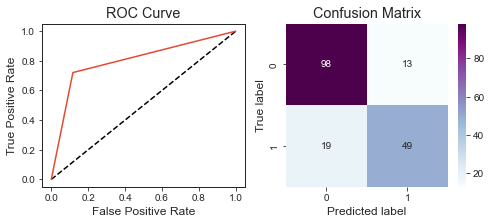

<Figure size 504x288 with 0 Axes>

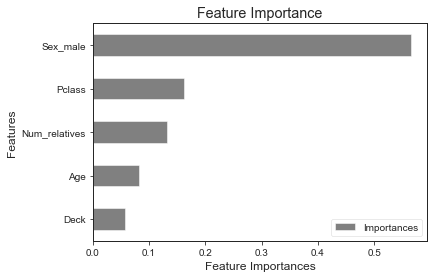

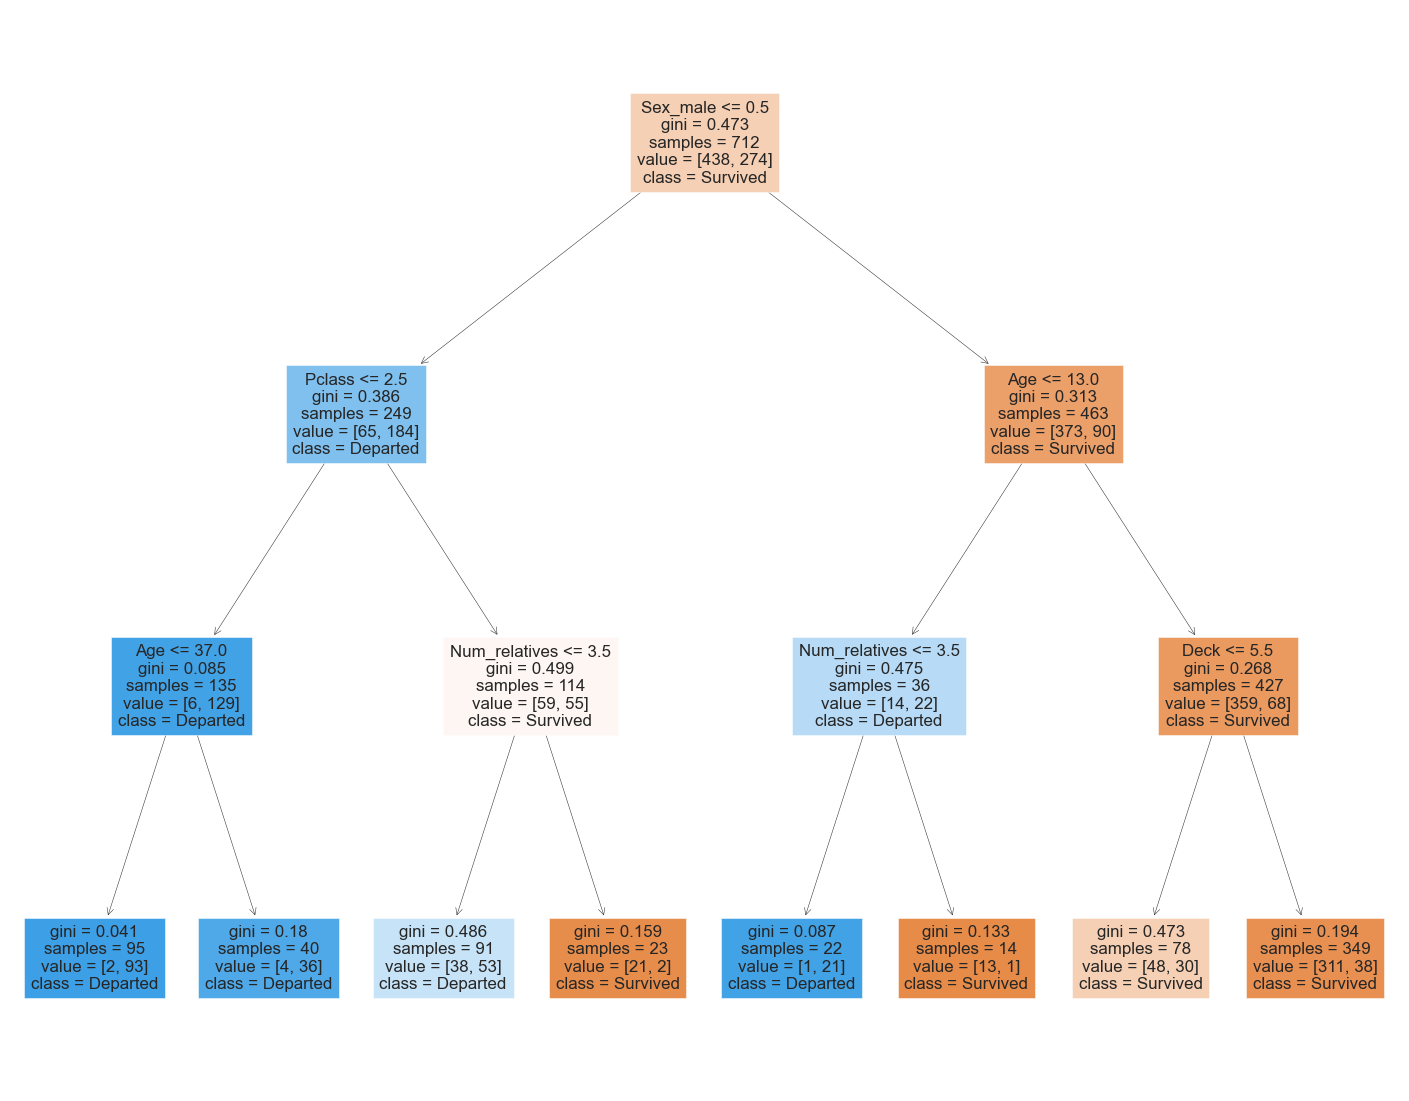

In [46]:
from sklearn.tree import DecisionTreeClassifier


# Choose variables to model
y = df_train['Survived']
X_var = ['Pclass','Age','Deck','Sex_male','Num_relatives']
to_scale = [None]
#best = 'Pclass','Age','Deck','Sex_male','Num_relatives'



X = df_train[X_var]
X_topredict = df_test[X_var]


steps = [('model', DecisionTreeClassifier())] # for printing title only

model = DecisionTreeClassifier()

# Specify hyperparameter space
parameters = {"criterion": ['gini', 'entropy'],
              "max_depth":range(1,10),
              #"min_samples_split":range(1,10),
              #"min_samples_leaf":range(1,5)
             }


# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=21)


# Instantiate the GridSearchCV object: cv
cv = model_selection.GridSearchCV(model,parameters, cv = 5)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the set: y_pred
y_pred = cv.predict(X_test)

# Store DT training accuracy
dt_train_accuracy = cv.score(X_test, y_test)


classification_metrics(cv)
    

features = X.columns.tolist()
importances = cv.best_estimator_.feature_importances_

feturedf=pd.DataFrame({'Features':features,'Importances':importances})
feturedf.sort_values('Importances',inplace=True)

fig = plt.figure(figsize=(7,4))
feturedf.plot(kind='barh',y='Importances',x='Features',color='gray')
plt.xlabel("Feature Importances")
plt.title('Feature Importance')
plt.show()

# Plot tree
from sklearn import tree
fig = plt.figure(figsize=(25,20))
graph = tree.plot_tree(cv.best_estimator_,
                   feature_names=X.columns,
                   class_names=['Survived', "Departed"],
                   filled=True)

predict_submission()

### 4.2.6 XGBoost

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
************************************************************
METHOD: XGBClassifier()
************************************************************

Features: ['Age', 'SibSp', 'Sex_male', 'Num_relatives', 'Deck']
Standardized features: ['Age', 'SibSp', 'Sex_male', 'Num_relatives', 'Deck']
Tuned Model Parameters: {'xgb__colsample_bytree': 0.6, 'xgb__eta': 0.4, 'xgb__max_depth': 3, 'xgb__n_estimators': 10, 'xgb__reg_alpha': 0.001, 'xgb__reg_lambda': 0.001}


========== Metrics ==========

Accuracy: 0.827
AUC: 0.812
R²: 0.827
Adjusted R²: 0.850


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       111
         1.0       0.78      0.75      0.77        68

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



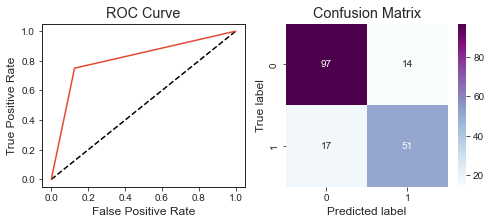

<Figure size 504x288 with 0 Axes>

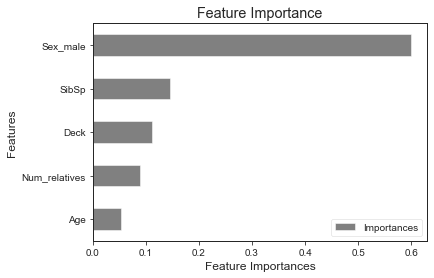

In [47]:
#from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb


# Choose variables to model
y = df_train['Survived']
X_var = ['Age','SibSp','Sex_male','Num_relatives','Deck']
to_scale = ['Age','SibSp','Sex_male','Num_relatives','Deck']
#best = ['Age','SibSp','Sex_male','Num_relatives','Deck']

X = df_train[X_var]
X_topredict = df_test[X_var]


# Set up pipeline
preprocessor = ColumnTransformer([('scaler', preprocessing.StandardScaler(),to_scale)],
                                 remainder='passthrough')

steps = [('preprocessor', preprocessor),
         ("model", xgb.XGBClassifier()),
        ]
    
pipeline = Pipeline(steps)

# Specify hyperparameter space
parameters = {'xgb__eta':[.4, .5, .6],
              'xgb__n_estimators': [10,20,50,100],
              'xgb__max_depth': [3,5,10],
              'xgb__reg_alpha': [0.001,0.01,0.1],
              'xgb__reg_lambda':[0.001,0.01,0.1],
              'xgb__colsample_bytree':[.6, .7, .8]
             }


# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=21)


# Instantiate the GridSearchCV object: cv
cv = model_selection.GridSearchCV(estimator = xgb.XGBClassifier(),
                                  param_grid = parameters,
                                  scoring = 'accuracy',
                                  cv = 3, verbose = 1)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the set: y_pred
y_pred = cv.predict(X_test)

# Store XGB training accuracy
xgb_train_accuracy = cv.score(X_test, y_test)


classification_metrics(cv)
    

features = X.columns.tolist()
importances = cv.best_estimator_.feature_importances_

feturedf=pd.DataFrame({'Features':features,'Importances':importances})
feturedf.sort_values('Importances',inplace=True)

fig = plt.figure(figsize=(7,4))
feturedf.plot(kind='barh',y='Importances',x='Features',color='gray')
plt.xlabel("Feature Importances")
plt.title('Feature Importance')
plt.show()

#from sklearn import tree
#fig = plt.figure(figsize=(25,20))
#graph = tree.plot_tree(cv.best_estimator_,
#                   feature_names=X.columns,
#                   class_names=['Survived', "Departed"],
#                   filled=True)


predict_submission()

### 4.2.7 Random Forest

Fitting 5 folds for each of 54 candidates, totalling 270 fits
************************************************************
METHOD: RandomForestClassifier()
************************************************************

Features: ['Age', 'SibSp', 'Fare_per_pax', 'Sex_male', 'Num_relatives', 'Deck']
Standardized features: [None]
Tuned Model Parameters: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 150}


========== Metrics ==========

Accuracy: 0.810
AUC: 0.793
R²: 0.810
Adjusted R²: 0.908


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85       111
         1.0       0.77      0.72      0.74        68

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



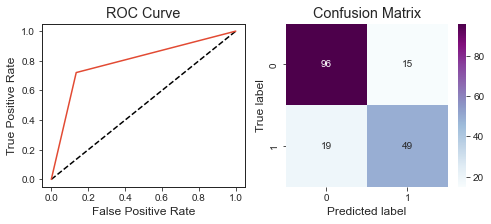

<Figure size 504x288 with 0 Axes>

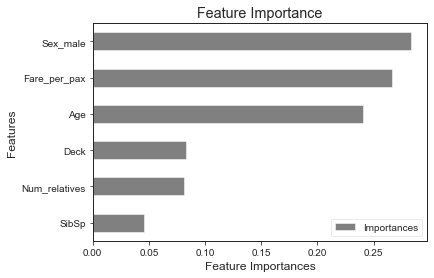

In [48]:
from sklearn.ensemble import RandomForestClassifier


# Choose variables to model
y = df_train['Survived']
X_var = ['Age','SibSp','Fare_per_pax','Sex_male','Num_relatives','Deck']
to_scale = [None]
# best = 'Age','SibSp','Fare_per_pax','Sex_male','Num_relatives','Deck'

X = df_train[X_var]
X_topredict = df_test[X_var]


steps = [('model', RandomForestClassifier())] # for printing title only

model = RandomForestClassifier()

# Specify hyperparameter space
parameters = {"n_estimators": [100,150,200],
              "criterion": ['gini', 'entropy'],
              "max_depth":range(1,10),
              #"min_samples_split":range(2,10),
              #"min_samples_leaf":range(2,5)
             }


# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=21)


# Instantiate the GridSearchCV object: cv
cv = model_selection.GridSearchCV(model, parameters,
                                  scoring = 'accuracy',
                                  cv = 5, verbose = 1)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the set: y_pred
y_pred = cv.predict(X_test)

# Store RF training accuracy
rf_train_accuracy = cv.score(X_test, y_test)


classification_metrics(cv)
    

features = X.columns.tolist()
importances = cv.best_estimator_.feature_importances_

feturedf=pd.DataFrame({'Features':features,'Importances':importances})
feturedf.sort_values('Importances',inplace=True)

fig = plt.figure(figsize=(7,4))
feturedf.plot(kind='barh',y='Importances',x='Features',color='gray')
plt.xlabel("Feature Importances")
plt.title('Feature Importance')
plt.show()

#from sklearn import tree
#fig = plt.figure(figsize=(25,20))
#graph = tree.plot_tree(cv.best_estimator_,
#                   feature_names=X.columns,
#                   class_names=['Survived', "Departed"],
#                   filled=True)


predict_submission()

## 4.3 Evaluate models
**Best model: SVC, testing accuracy = 78%**

Based on the scores on the training set and Kaggle. Hover over the plot below to see the accuracy scores for each model.

To recap, the features in the SVC model are:
1. Sex
2. Age
3. Number of relatives
4. Pclass

In [49]:
accuracy_scores = {'model':["SVC", "Decision Tree","XGBoost","Logistic Regression","KNN Classifier","Gaussian Naive Bayes","Random Forest"],
        'kaggle_accuracy': [0.78468,0.77511,0.76794,0.75837,0.75358,0.75358,0.75358], 
        'training_accuracy': [svc_train_accuracy,dt_train_accuracy,xgb_train_accuracy,logreg_train_accuracy,knn_train_accuracy,nb_train_accuracy,rf_train_accuracy],
        
       }

# pass column names in the columns parameter 
df_scores = pd.DataFrame(accuracy_scores)
df_scores

import plotly.express as px
fig = px.scatter(df_scores, x='training_accuracy', y='kaggle_accuracy',hover_data=['model'])
fig.show()

# 5. Summary and Learning Points

**Q: “What sorts of people were more likely to survive?”**

Based on the SVC model selected (78% accuracy), the following are more likely to survive
1. Females
2. Younger persons
3. Those with more relatives on board
4. Those in a higher Pclass

**Learning points**

1. Feature selection has the most significant impact on the model.
2. Strong predictors aren’t always a good thing. 
3. Concise and easy-to-implement models are the best.
4. The models generated may have some overfitting since the testing scores dropped by ~4 percentage points, but this is acceptable.
5. There’s room to explore stacking methods too.
